# Preprocess the data

In [22]:
import pandas as pd
import numpy as np
import os

main_data = pd.read_excel("total_cost_per_office_normalized.xlsx")

city_data_combined = pd.DataFrame()
city_data_folder = "classified by city"

# Iterate through the files in the folder
for file in os.listdir(city_data_folder):
    city = os.path.splitext(file)[0] 
    city_data = pd.read_csv(os.path.join(city_data_folder, file))
    for col in city_data.columns[1:]:
        if isinstance(city_data[col].iloc[0], str):
            city_data[col] = city_data[col].str.replace(',', '').astype(float)
    city_data['office_location'] = city
    city_data_combined = pd.concat([city_data_combined, city_data])

# Merge main_data with city_data_combined on 'year', 'office_location'
main_data['year'] = main_data['year'].astype(int)
city_data_combined = city_data_combined.reset_index().drop(['index'],axis=1)
city_data_combined = city_data_combined.rename(columns={'Year': 'year'})

In [24]:
city_data_combined.head()

,year,Bankruptcy Totals,Employment Totals,GDP,New Grads,HPI,PerCap Dispo Income,PerCap Personal Income,REVENUE,office_location,Bar Pass
0,2006,11226.0,2413797.0,207773.8,52421.0,168.62,30793.0,33850.0,NaN,BatonRouge,NaN
1,2007,14277.0,2501135.0,203041.0,52465.0,185.64,32840.0,36432.0,NaN,BatonRouge,NaN
2,2008,15555.0,2550836.0,212392.4,62148.0,190.59,34633.0,38522.0,NaN,BatonRouge,NaN
3,2009,18780.0,2529953.0,204906.9,65823.0,191.69,33994.0,36930.0,NaN,BatonRouge,NaN
4,2010,19159.0,2536560.0,225308.9,70272.0,188.27,35295.0,38242.0,NaN,BatonRouge,NaN


In [25]:
main_data.head()

,year,month,office_location,normalized_cost
0,2014,January,Baton Rouge,0.035717
1,2014,January,Dallas/Fort Worth,0.006118
2,2014,January,Gulfport,0.003695
3,2014,January,Houston,0.015981
4,2014,January,Jackson,0.026757


# Merge data

In [42]:
merged_data = main_data.merge(city_data_combined, on=['year', 'office_location'])

In [43]:
merged_data.head()

,year,month,office_location,normalized_cost,Bankruptcy Totals,Employment Totals,GDP,New Grads,HPI,PerCap Dispo Income,PerCap Personal Income,REVENUE,Bar Pass
0,2014,January,Gulfport,0.003695,11106.0,1556753.0,104300.3,42255.0,168.34,32125.0,34896.0,0.007576,NaN
1,2014,February,Gulfport,0.006198,11106.0,1556753.0,104300.3,42255.0,168.34,32125.0,34896.0,0.007576,NaN
2,2014,March,Gulfport,0.008961,11106.0,1556753.0,104300.3,42255.0,168.34,32125.0,34896.0,0.007576,NaN
3,2014,April,Gulfport,0.012874,11106.0,1556753.0,104300.3,42255.0,168.34,32125.0,34896.0,0.007576,NaN
4,2014,May,Gulfport,0.016962,11106.0,1556753.0,104300.3,42255.0,168.34,32125.0,34896.0,0.007576,NaN


In [44]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 0 to 863
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    864 non-null    int32  
 1   month                   864 non-null    object 
 2   office_location         864 non-null    object 
 3   normalized_cost         864 non-null    float64
 4   Bankruptcy Totals       864 non-null    float64
 5   Employment Totals       768 non-null    float64
 6   GDP                     768 non-null    float64
 7   New Grads               672 non-null    float64
 8   HPI                     396 non-null    float64
 9   PerCap Dispo Income     768 non-null    float64
 10  PerCap Personal Income  768 non-null    float64
 11  REVENUE                 864 non-null    float64
 12  Bar Pass                576 non-null    float64
dtypes: float64(10), int32(1), object(2)
memory usage: 91.1+ KB


In [45]:
numeric_columns = merged_data.select_dtypes(include=[np.number])
column_means = numeric_columns.mean()
merged_data.fillna(column_means, inplace=True)
merged_data = pd.get_dummies(merged_data, columns=['month', 'office_location'])
merged_data.to_csv("preprocessed_data.csv", index=False)

# Build model

In [53]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# load data
data = pd.read_csv("preprocessed_data.csv")
y = data['normalized_cost']
X = data.drop('normalized_cost', axis=1)

regression = LinearRegression()
regression.fit(X, y)

y_pred = regression.predict(X)
y_pred[y_pred<0] = 0.01
r_squared = r2_score(y, y_pred)
print("R-squared value:", r_squared)

coefficients = pd.Series(regression.coef_, index=X.columns)
impact = coefficients.sort_values(ascending=False)
print("\nImpact of each variable on cost (sorted by magnitude):")
print(impact)

R-squared value: 0.8341510503109394

Impact of each variable on cost (sorted by magnitude):
REVENUE                        6.889859e-01
month_December                 9.555596e-02
month_November                 7.619914e-02
month_October                  5.914912e-02
office_location_Houston        4.698981e-02
office_location_Jackson        4.248887e-02
month_September                3.971064e-02
office_location_Gulfport       3.294861e-02
office_location_Raleigh        2.802984e-02
month_August                   2.328727e-02
office_location_Tupelo         1.899706e-02
office_location_Mobile         9.907981e-03
month_July                     6.810932e-03
HPI                            3.576548e-05
PerCap Dispo Income            2.724738e-06
Bankruptcy Totals              2.297434e-07
Employment Totals              8.414725e-09
New Grads                     -4.221056e-08
GDP                           -7.361409e-08
PerCap Personal Income        -1.525202e-06
Bar Pass                    

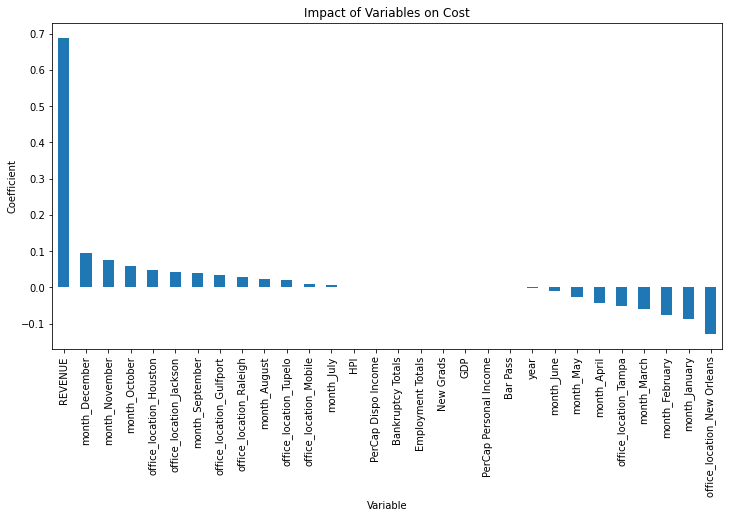

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
impact.plot(kind='bar')
plt.title('Impact of Variables on Cost')
plt.ylabel('Coefficient')
plt.xlabel('Variable')

plt.show()

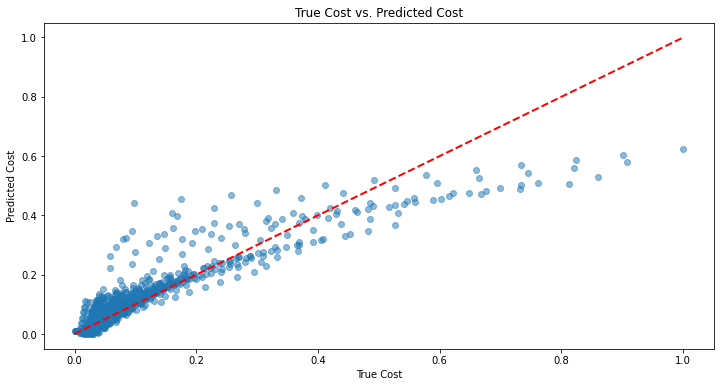

In [55]:

plt.figure(figsize=(12, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('True Cost vs. Predicted Cost')
plt.xlabel('True Cost')
plt.ylabel('Predicted Cost')
plt.show()
